### Importando bibliotecas necessárias

In [1]:
import pandas as pd
import csv

from graph_tool import Graph
import os
from graph_tool import util
import netpixi
import pickle
import warnings
warnings.filterwarnings("ignore")

from regression.integration.gt import *
from netpixi.integration.gt import *

### Dataset NBA players

In [2]:
import pandas as pd
df=pd.read_csv("all_seasons.csv")
df_new=df[['player_name','team_abbreviation','season']]
df_new

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


,player_name,team_abbreviation,season
0,Dennis Rodman,CHI,1996-97
1,Dwayne Schintzius,LAC,1996-97
2,Earl Cureton,TOR,1996-97
3,Ed O'Bannon,DAL,1996-97
4,Ed Pinckney,MIA,1996-97
...,...,...,...
12300,Markieff Morris,MIA,2021-22
12301,Markelle Fultz,ORL,2021-22
12302,Marcus Smart,BOS,2021-22
12303,Marcus Garrett,MIA,2021-22


### Criação do grafo

In [3]:
from netpixi.integration.gt import Graph

g = Graph(directed=False) # não dirigido

In [4]:
# lista de jogadores
players = df_new['player_name'].unique().tolist()

In [5]:
# adicionar nós para cada jogador
for player in players:
    g.add_vertex(player)
    diogo = g.get_vertex(player)
    g.add_vp('nome')
    diogo['nome'] = player
#     print(player)
    

In [6]:
N=3
# filtra os jogadores que jogaram juntos por mais de 2 temporadas
df_filtered = df_new.groupby(['team_abbreviation', 'player_name']).filter(lambda x: x['season'].nunique() > N)

# adiciona as arestas ao grafo
for _, group in df_filtered.groupby(['team_abbreviation', 'season']):
    players = group['player_name'].tolist()
    for i in range(len(players)):
        for j in range(i+1, len(players)):
            # verifica se os jogadores jogaram juntos por mais de N temporadas
            num_seasons = len(set(df_new[(df_new['player_name']==players[i]) & (df_new['team_abbreviation']==group['team_abbreviation'].iloc[0])]['season']).intersection(
                                set(df_new[(df_new['player_name']==players[j]) & (df_new['team_abbreviation']==group['team_abbreviation'].iloc[0])]['season'])))
            if num_seasons > N:
                # verifica se a aresta não existe no grafo
                if not g.has_edge(players[i], players[j]):
                    # adiciona a aresta ao grafo
                    g.add_edge(players[i], players[j])
                    e = g.get_edge(players[i], players[j])
                    g.add_ep('seasons_jogadas')
                    e['seasons_jogadas'] = num_seasons
                    


### Análise Exploratória

#### a) Número de vértices, arestas, densidade

In [7]:
#número de vértices
n = g.num_vertices()
print('O número de vértices é {0}'.format(n))

O número de vértices é 2463


In [8]:
#número de arestas
m = g.num_edges()
print('O número de arestas é {0}'.format(m))

O número de arestas é 1411


In [9]:
##densidade
max_edges = n * (n - 1)
d = m / max_edges
print('A densidade é {0}'.format(round(d,4)))

A densidade é 0.0002


In [10]:
data_targets = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
data_targets.head()

,id,nome
0,Dennis Rodman,Dennis Rodman
1,Dwayne Schintzius,Dwayne Schintzius
2,Earl Cureton,Earl Cureton
3,Ed O'Bannon,Ed O'Bannon
4,Ed Pinckney,Ed Pinckney


#### B) Estatísticas e histograma do degree. (não é necessário in-degree e out-degree)

In [11]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

data_targets['degree'] = degrees
data_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2463 non-null   object
 1   nome    2463 non-null   object
 2   degree  2463 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 57.9+ KB


count    2463.000000
mean        1.145757
std         2.546614
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        23.000000
Name: degree, dtype: float64

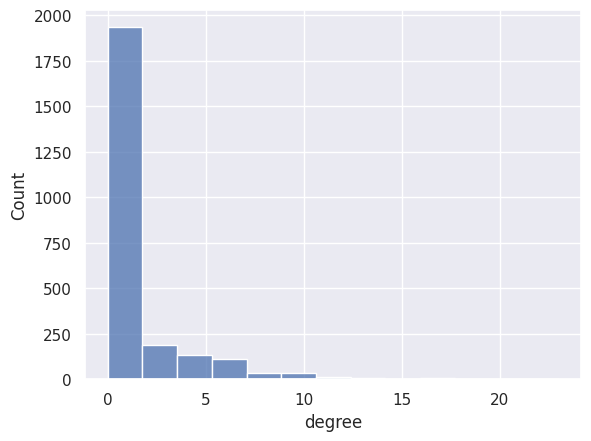

In [12]:
import seaborn as sns
sns.histplot(data_targets['degree'])
data_targets['degree'].describe()

### Análise Visual do Grafo

#### A) Salvando o arquivo

In [13]:
g = gt_clean(g)
gt_save(g,'Nba_teams.gz')

#### B) Visualizando o grafo

In [14]:
g = gt_load('Nba_teams.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g,'Nba_teams.gz')
r=netpixi.render('Nba_teams.gz',infinite=True);

#### C) Ajustando as propriedades visuais do grafo

In [15]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=5)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

### Modificando data

In [16]:
#fazer esse dataframe anterior em menos passos
df_career = df.groupby('player_name').agg({'season': 'nunique', 'net_rating': 'mean', 'draft_number': 'max', 'draft_year':'unique'}).reset_index()
df_career = df_career.rename(columns={'season': 'num_seasons', 'net_rating': 'career_net_rating'})

#replace dos valores de draft_number para inteiros e "undrafetd" para -1
df_career['draft_number'] = df_career['draft_number'].replace('Undrafted', -1).astype(int)
df_career['draft_year'] = df_career['draft_year'].apply(lambda x: x[0])
df_career['draft_year'] = df_career['draft_year'].replace('Undrafted', -1).astype(int)

#criar um novo dataframe com os draftados depois de 1990
# df_career = df_career[df_career['draft_year'] >= 1993]
df_career

,player_name,num_seasons,career_net_rating,draft_number,draft_year
0,A.C. Green,5,-1.880000,23,1985
1,A.J. Bramlett,1,-32.600000,39,1999
2,A.J. Guyton,3,-6.700000,32,2000
3,AJ Hammons,1,-0.600000,46,2016
4,AJ Price,6,-2.233333,52,2009
...,...,...,...,...,...
2458,Zion Williamson,2,3.600000,1,2019
2459,Zoran Dragic,1,-15.300000,-1,-1
2460,Zoran Planinic,3,-6.233333,22,2003
2461,Zydrunas Ilgauskas,13,2.107692,20,1996


### Clustering Coefficient

In [17]:
#calculando clustering coefficient:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
data_clustering=gt_data(g)

In [18]:
#renomar a coluna clustering para clustering_coefficient e acrescentar a coluna player_name e o id virar numero
data_clustering=data_clustering.reset_index().rename(columns={'id': 'player_name'})
data_clustering

,player_name,nome,clustering
0,0,Eddie Jones,0.000000
1,1,Eric Piatkowski,1.000000
2,2,Eric Snow,0.333333
3,3,Eric Williams,1.000000
4,4,Erick Dampier,0.392857
...,...,...,...
491,491,Luka Doncic,1.000000
492,492,Mo Bamba,1.000000
493,493,Jalen Brunson,1.000000
494,494,Jaren Jackson Jr.,1.000000


In [19]:
df_career_filtered = df_career[df_career['player_name'].isin(data_clustering['nome'])]

In [20]:
lista_clustering =[]
#pegar valores de clustering_coefficient dos jogadores que estao no dataframe df_career
for index,row in data_clustering.iterrows():
    if row['nome'] in df_career_filtered['player_name'].values:
        lista_clustering.append(row['clustering'])
df_career_filtered['clustering_coefficient'] = lista_clustering
df_career_filtered

/tmp/ipykernel_14/2846346443.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_career_filtered['clustering_coefficient'] = lista_clustering


,player_name,num_seasons,career_net_rating,draft_number,draft_year,clustering_coefficient
6,Aaron Gordon,8,-0.387500,4,2014,0.000000
12,Aaron McKie,11,0.672727,17,1994,1.000000
16,Aaron Williams,12,-5.050000,-1,-1,0.333333
21,Adam Keefe,5,1.620000,10,1992,1.000000
26,Adonal Foyle,12,-4.400000,8,1997,0.392857
...,...,...,...,...,...,...
2422,Wilson Chandler,12,-1.358333,23,2007,1.000000
2434,Yao Ming,8,2.012500,1,2002,1.000000
2447,Zach Randolph,17,-2.158824,19,2001,1.000000
2451,Zaza Pachulia,16,0.350000,42,2003,1.000000


In [21]:
# Descomente para rodar para cada recorte

# Primeiro Recorte

# df_career_filtered = df_career_filtered[df_career_filtered['draft_year'] >= 2003]
# df_career_filtered = df_career_filtered[df_career_filtered['draft_number'] <= 10]
# df_career_filtered = df_career_filtered[df_career_filtered['career_net_rating'] >= -5]
# # df_career_filtered = df_career_filtered[df_career_filtered['num_seasons'] >= 5]
# # df_career_filtered.shape


# Segundo Recorte


### Regressão Linear

### Experiência vs potencial

In [22]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_career_filtered,formula=' num_seasons~draft_number')


In [23]:
result.micro_summary()

variable,coefficient,std error,p-value
draft_number,-0.027202,0.011063,0.014284


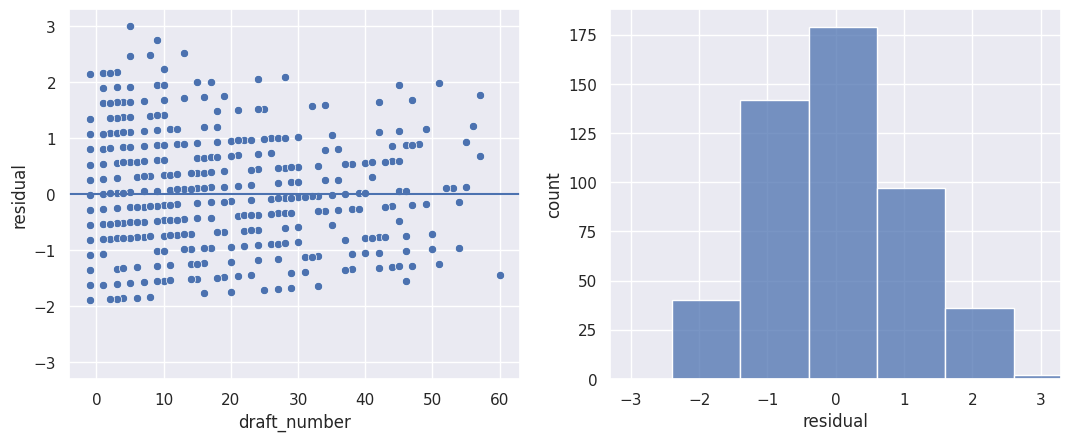

In [24]:
result.plot_residuals(df_career_filtered['draft_number'])

### Experiência vs Impacto

In [25]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_career_filtered,formula=' num_seasons~career_net_rating')

In [26]:
result.micro_summary()

variable,coefficient,std error,p-value
career_net_rating,0.179379,0.038942,0.000005


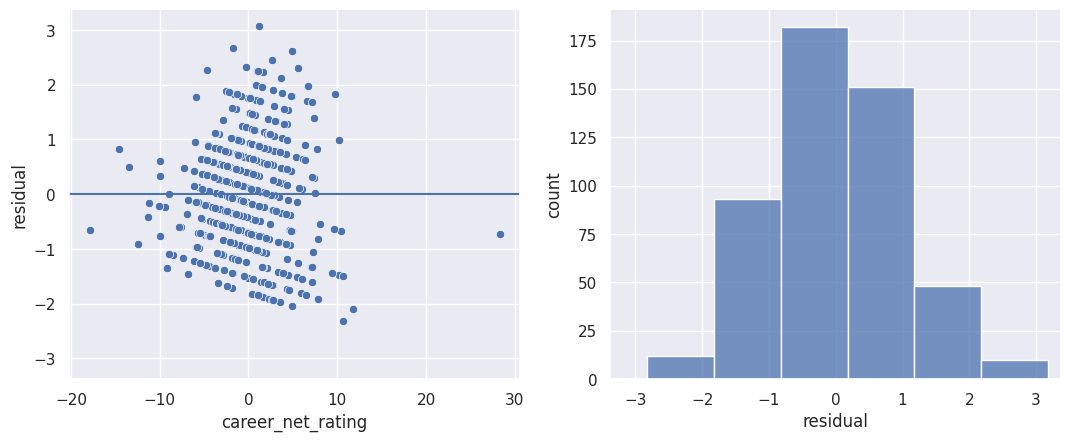

In [27]:
result.plot_residuals(df_career_filtered['career_net_rating'])

### Experiência vs adaptabilidade

In [28]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_career_filtered,formula='num_seasons~clustering_coefficient')

In [29]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering_coefficient,0.441449,0.492483,0.370489


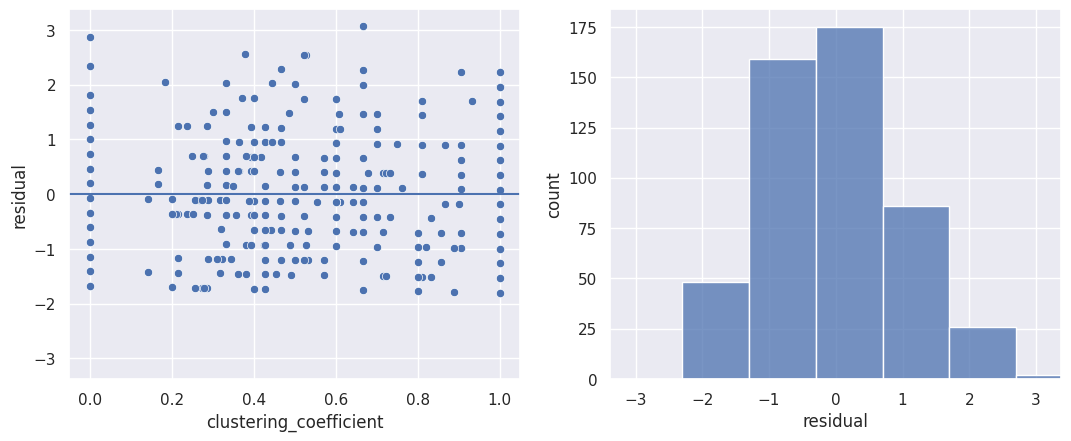

In [30]:
result.plot_residuals(df_career_filtered['clustering_coefficient'])

### Análise Multivariada

In [31]:
result=reg.linear(data=df_career_filtered,formula=' num_seasons~draft_number+career_net_rating+clustering_coefficient')
result.micro_summary()

variable,coefficient,std error,p-value
draft_number,-0.027987,0.010846,0.010155
career_net_rating,0.179341,0.038772,0.000005
clustering_coefficient,0.380971,0.480600,0.428335


### Gráficos de Residuos


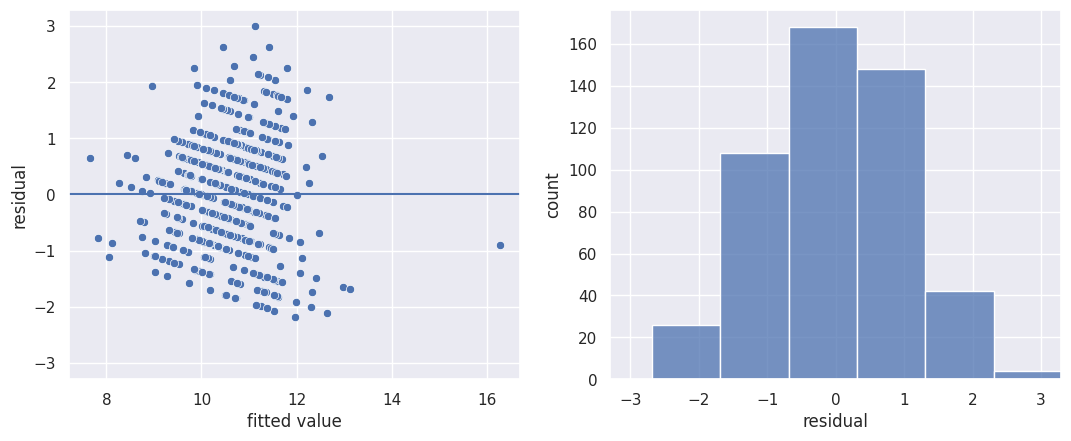

In [32]:
result.plot_residuals()